**HuBMAP - Hacking the Human Vasculature**

Segment instances of microvascular structures from healthy human kidney tissue slides.

**Goal of the Competition**

The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. You'll create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

Your help in automating the segmentation of microvasculature structures will improve researchers' understanding of how the blood vessels are arranged in human tissues.

**Context**

The proper functioning of your body's organs and tissues depends on the interaction, spatial organization, and specialization of your cells—all 37 trillion of them. With so many cells, determining their functions and relationships is a monumental undertaking.

Current efforts to map cells involve the Vasculature Common Coordinate Framework (VCCF), which uses the blood vasculature in the human body as the primary navigation system. The VCCF crosses all scale levels--from the whole body to the single cell level--and provides a unique way to identify cellular locations using capillary structures as an address. However, the gaps in what researchers know about microvasculature lead to gaps in the VCCF. If we could automatically segment microvasculature arrangements, researchers could use the real-world tissue data to begin to fill in those gaps and map out the vasculature.

Competition host Human BioMolecular Atlas Program (HuBMAP) hopes to develop an open and global platform to map healthy cells in the human body. Using the latest molecular and cellular biology technologies, HuBMAP researchers are studying the connections that cells have with each other throughout the body.

There are still many unknowns regarding microvasculature, but your Machine Learning insights could enable researchers to use the available tissue data to augment their understanding of how these small vessels are arranged throughout the body. Ultimately, you'll be helping to pave the way towards building a Vascular Common Coordinate Framework (VCCF) and a Human Reference Atlas (HRA), which will identify how the relationships between cells can affect our health.

In [222]:
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import staintools

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
train = glob.glob("/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/train/*")
test = glob.glob("/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/test/*")

In [9]:
# Create a dictionary to hold the blood_vessel annotations for each image
blood_vessel_annotations = {}

# Open the annotations file
with open('/content/drive/MyDrive/Kaggle/HuBMAP - Hacking the Human Vasculature/Dataset/Data/polygons.jsonl', 'r') as f:
    # For each line in the file
    for line in f:
        # Parse the line as JSON
        annotation = json.loads(line)

        # Get the image ID and the list of annotations for this image
        image_id = annotation['id']
        image_annotations = annotation['annotations']

        # Filter the annotations to keep only the blood_vessel ones
        blood_vessel_annotations_for_this_image = [a for a in image_annotations if a['type'] == 'blood_vessel']

        # Store the blood_vessel annotations in the dictionary
        blood_vessel_annotations[image_id] = blood_vessel_annotations_for_this_image

In [179]:
# map images
image_map = {impath.split('/')[-1].split('.')[0]: impath for impath in train}
image_map.update({impath.split('/')[-1].split('.')[0]: impath for impath in test})

Stain normalization use was refrenced from RAVI SHAH ["StainTools for Augmentation"](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/discussion/412396) thank you

In [235]:
def preprocess_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image = cv2.resize(image, (512 , 512))

    # Normalize image to 0-1
    image = image / 255.0

    
    # Standardize the luminosity
    image_standardized = staintools.LuminosityStandardizer.standardize(image_rgb)

    # Initialize stain normalizer
    normalizer = staintools.StainNormalizer(method='vahadane')

    # Fit on the target image
    normalizer.fit(target_image)

    # Transform the input image
    transformed_image = normalizer.transform(image_standardized)

    return transformed_image

In [231]:
# Assume the first image in your dataset is the target for stain normalization
target_image_path = image_map[list(image_map.keys())[0]]
target_image = cv2.cvtColor(cv2.imread(target_image_path), cv2.COLOR_BGR2RGB)
target_image = staintools.LuminosityStandardizer.standardize(target_image)

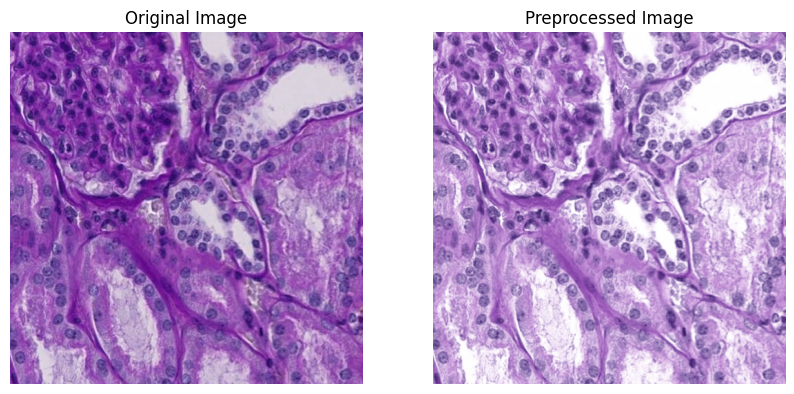

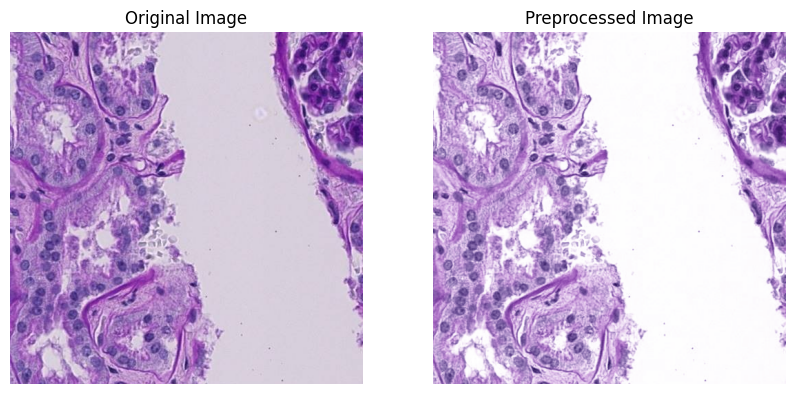

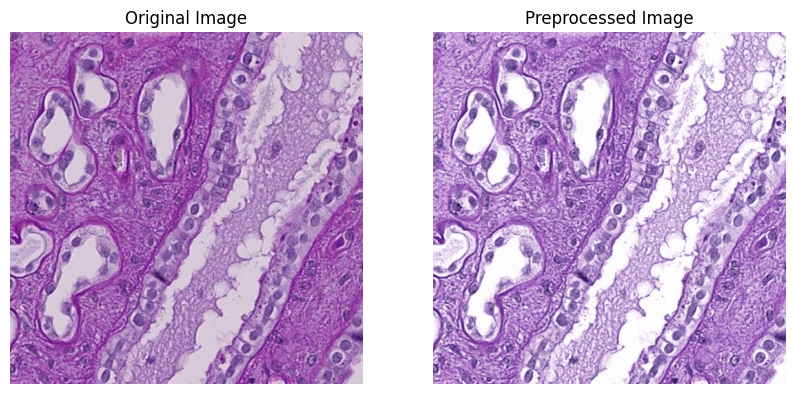

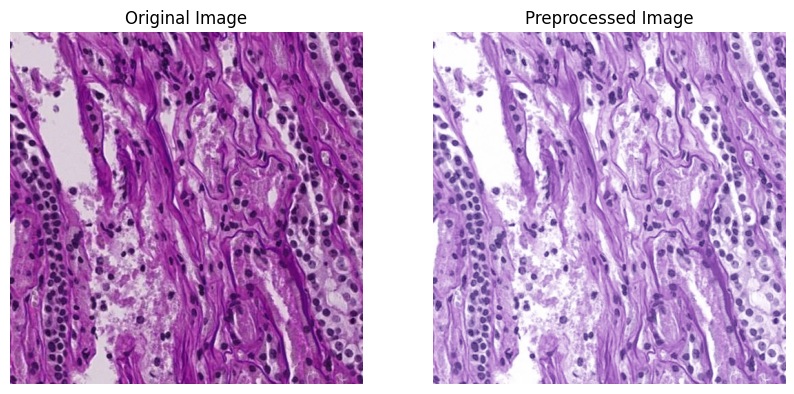

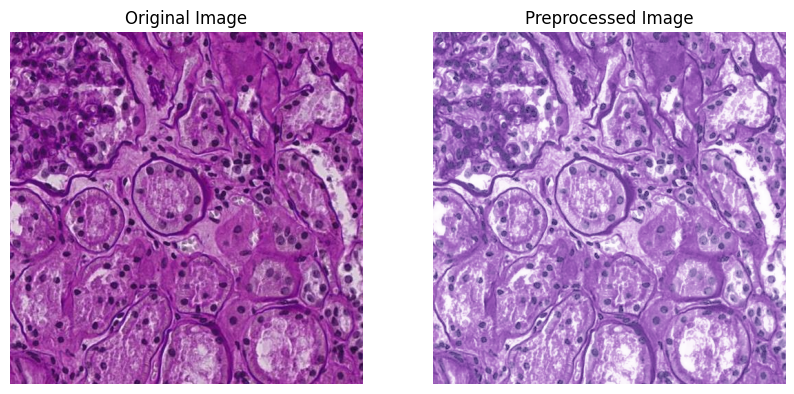

In [ ]:
preprocessed_images = {}
for i, image_id in enumerate(list(blood_vessel_annotations.keys())):
    # Open the image file
    if image_id in image_map:
        image = cv2.imread(image_map[image_id])
        preprocessed_image = preprocess_image(image.copy())
        preprocessed_images[image_id] = preprocessed_image

        # For the first 5 images, display the original and preprocessed image side by side
        if i < 5:
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
            plt.title("Preprocessed Image")
            plt.axis('off')

            plt.show()

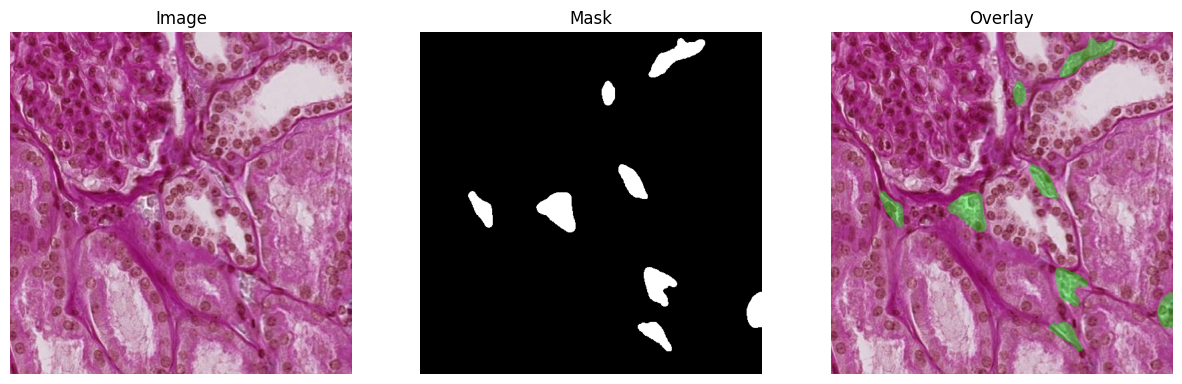

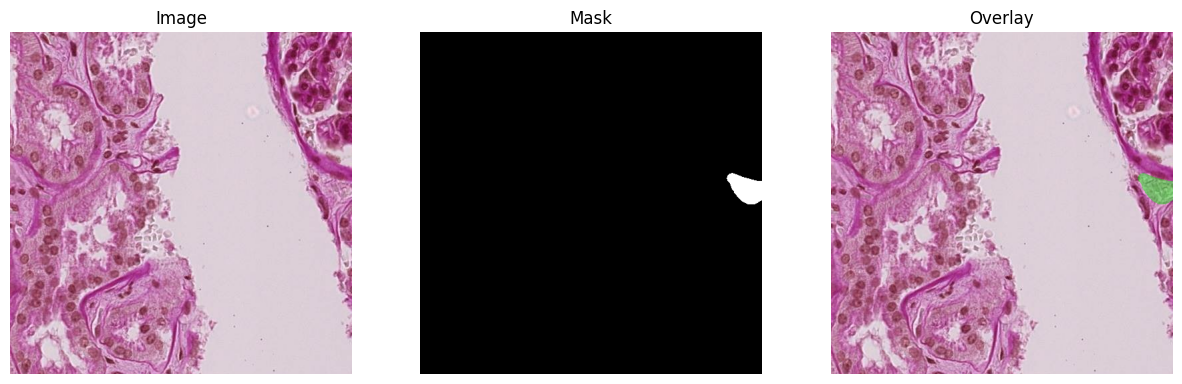

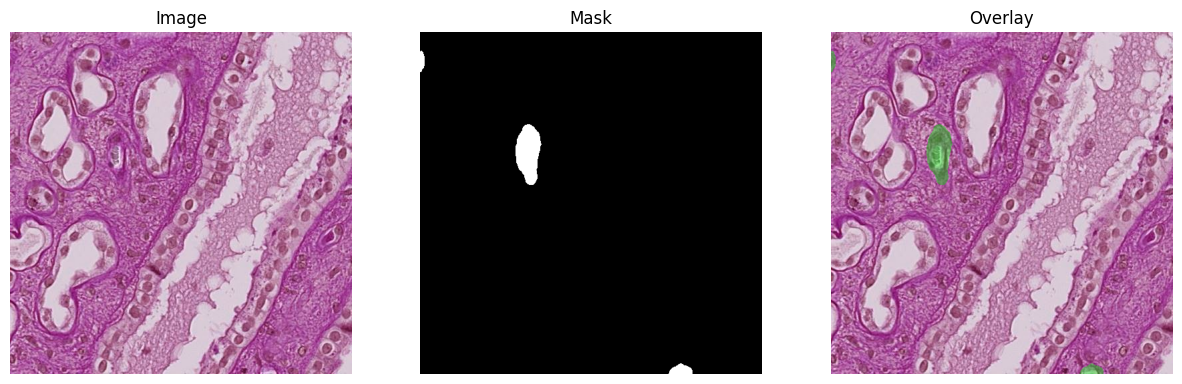

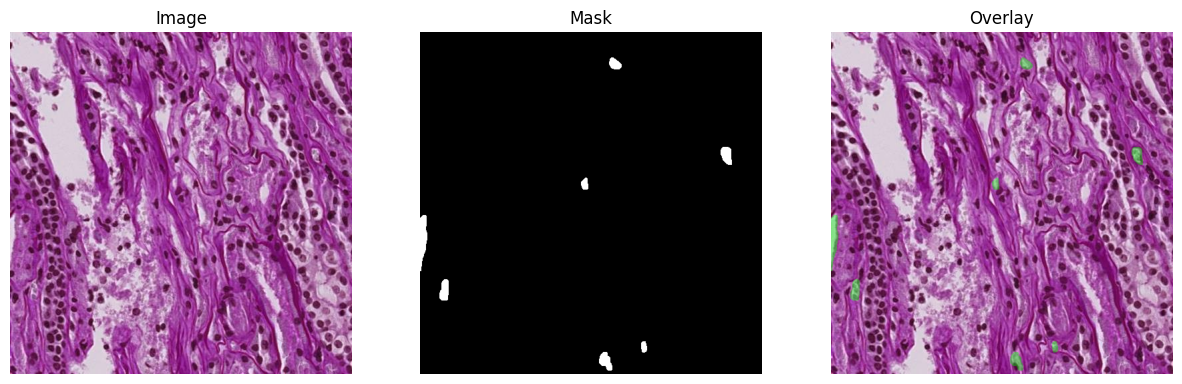

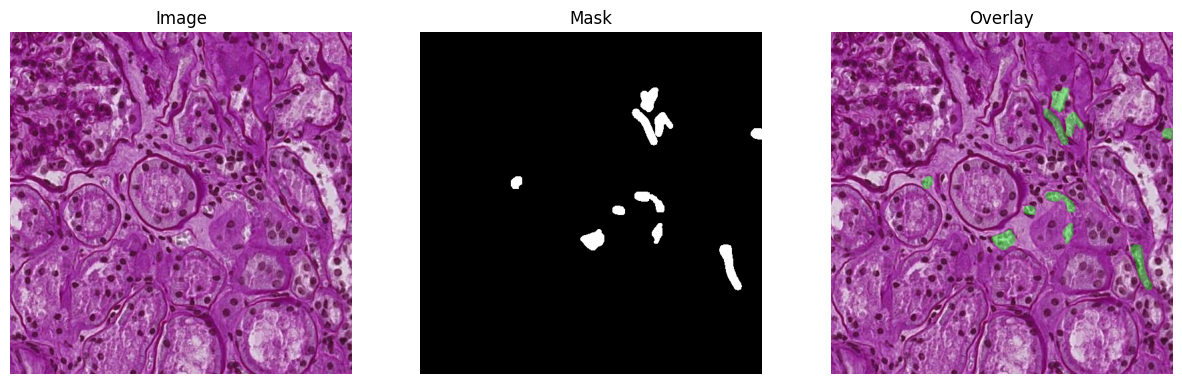

In [217]:
masks = {}

for image_id in blood_vessel_annotations.keys():
    if image_id in image_map:
        polygons = blood_vessel_annotations[image_id]
        # get the image
        preprocessed_images[image_id]
        # Create an empty mask of the same size as the image
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # For each polygon (representing a blood vessel)
        for polygon in polygons:
            lines = np.array(polygon['coordinates'])
            lines = lines.reshape(-1, 1, 2)
            # Draw the polygon on the mask
            cv2.fillPoly(mask, [lines], 255)
        
        masks[image_id] = mask

        # If it's one of the first 5 images, display it
        if len(masks) < 6:
          # Overlay the mask on the image
          overlay = image.copy()
          overlay[mask > 0] = [0, 255, 0]  # change mask color on the overlay if needed
          # Display the image, the mask, and the overlay side by side
          plt.figure(figsize=(15,5))
          plt.subplot(1,3,1)
          plt.imshow(image)
          plt.title('Image')
          plt.axis('off')
          plt.subplot(1,3,2)
          plt.imshow(mask, cmap='gray')
          plt.title('Mask')
          plt.axis('off')
          plt.subplot(1,3,3)
          plt.imshow(image)
          plt.imshow(overlay, alpha=0.4)  # change alpha to adjust transparency
          plt.title('Overlay')
          plt.axis('off')
          plt.show()